<a href="https://colab.research.google.com/github/SauloSilva/IPCV-2020/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment 2**
Intructions for the assignment: [link](https://daniel-yukimura.github.io/ipcv-2020-assignment-2/)

### **Part 0: Setup**
As in the first assignment you must follow the steps for setting your Google Colab environment - [Assignment-1](https://colab.research.google.com/drive/1t8gHrqvAQ_ip2Dr6nI3JOnkgRiSVqhAd?usp=sharing).
While preparing the notebook, we suggest you already import the modules you used in the previous clas. Also, since we'll be doing image classification with larger models, we suggest you already set the runtime of the Colab notebook to work with the GPU setting.


In [1]:
##############################################################################
# Setup
##############################################################################

from google.colab import drive
drive.mount('/content/drive')

%cd drive/'My Drive'/IPCV-2020/Assignment-2/

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)


Mounted at /content/drive
/content/drive/My Drive/IPCV-2020/Assignment-2
1.7.0+cu101


In [2]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if cuda else "cpu")

def to_cuda(x):
  return x.to(DEVICE)

### **Part 1: Convolutional Neural Networks (CNN)**

In the first part of this assignment we'll be setting a CNN using PyTorch. For that we'll see how to choose the dimensions and kernel sizes, in order to correctly match the dimensions while modeling a CNN. We start by observing a base example which we'll be using throughout this part of the assignment. We'll be training the model on the MNIST dataset as in the previous assignment.

In [3]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.cv1 = nn.Conv2d(1,24, kernel_size=5, stride=1, padding=2)
        self.cv2 = nn.Conv2d(24,48, kernel_size=5, stride=1, padding=2)
        self.fc = nn.Linear(7*7*48, 10)

    def forward(self, x):
        out = F.relu(F.max_pool2d(self.cv1(x), 2))
        out = F.relu(F.max_pool2d(self.cv2(out), 2))
        out = out.view(-1,7*7*48)
        return self.fc(out)

### **Base model**:
We'll make a lot of tests and changes based on this model, therefore we recommend that while solving this problems you create test functions in the notebook, or in a python script, in order to reuse your code.

For the next exercises you should record the performance of your training using a validation step, you'll use this data for comparing the perfomance between models. We also recommend a list of hyperparameters for the initial setting
* number of epochs: 20
* learning rate: 0.001
* batch size: 64

**Instruction:** The goal of the following exercises is to improve the base model. Therefore, we suggest the following practices when doing your analysis:
* After each exercise where an improvement is required, we ask that you plot a comparison graph between the perfomances of all changes in question. 
* Write a brief comment on which one is the best choice, and why is that the case. 
* You should compare them using the accuracy measure on you validation split. 
* For the cases where models have similar perfomance, the simpler (less parameters) should be the one to prevail.
* After selecting a change, you should maintain this change for the next exercise.
* We recommend you get use to saving and loading your models too - [Tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).
-----

1. Load the MNIST dataset and train the given base model. Here you can essentially use the same settings you have used in the first assingment.


In [4]:
##############################################################################
# Code
##############################################################################

# BASE VARS

n_epochs = 20
batch_size = 64
loss = nn.CrossEntropyLoss()

# DATA

mnist_transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
mnist_data = MNIST(os.getcwd(), train=True, download=True, transform=mnist_transform)
mnist_train, mnist_val = random_split(mnist_data, [55000, 5000])
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=mnist_transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size)
test_loader = DataLoader(mnist_test, batch_size=batch_size)
val_loader = DataLoader(mnist_val, batch_size=batch_size)

In [5]:
import tqdm

def test_step(model, loader):
  with torch.no_grad():
    correct, total, error = 0, 0, 0

    for images, labels in loader:
      images = to_cuda(images)
      labels = to_cuda(labels)
      outputs = model(images)

      error += loss(outputs, labels)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().detach().item()

    return correct / total, error / len(loader)

def train(model, cfg, save_step=100, num_epochs=20, show=True):
  optim_method = getattr(torch.optim, cfg.get('optim', 'SGD'))
  optim = optim_method(model.parameters(), lr=cfg.get("learning_rate", 0.01))

  val_loss = []
  val_acc = []

  count = 0
  outer_bar = tqdm.notebook.tqdm(total=num_epochs, desc="Epochs", position=0)
  inner_bar = tqdm.notebook.tqdm(total=len(mnist_train) / batch_size, desc="Epochs", position=1)
  loss_bar = tqdm.notebook.tqdm(total=len(mnist_train) / batch_size, bar_format="{postfix[0]} {postfix[1][loss]:>8.2g}", postfix=["Loss", dict(loss=0)])

  for epoch in range(num_epochs):
    inner_bar.reset()
    loss_bar.reset()

    for idx, (img_batch, y_batch) in enumerate(train_loader):
      img_batch = to_cuda(img_batch)
      y_batch = to_cuda(y_batch)

      y_pred = model(img_batch)
      error = loss(y_pred, y_batch)

      optim.zero_grad()
      error.backward()
      optim.step()

      inner_bar.update()
      loss_bar.postfix[1]["loss"] = error.item()
      loss_bar.update()
      count += 1

      if (count + 1) % save_step == 0:
        acc, loss_val = test_step(model, val_loader)
        val_acc.append(acc)
        val_loss.append(loss_val)

        if (count + 1) % save_step == 0 and show:
          print("Acurracy: {}".format(100 * acc))

    outer_bar.update()
  return val_loss, val_acc


In [ ]:
CNN = to_cuda(ConvNN())
cfg = {"learning_rate": 0.001, "optim": "SGD"}

val_loss, val_acc = train(CNN, cfg)

In [10]:
acc, error = test_step(CNN, test_loader)
print("Accuracy {}".format(100*acc))

Accuracy 97.7


In [12]:
torch.save(CNN.state_dict(), 'checkpoint/base_train.pt')

### **Optimization**

2. Your first task is to improve the optimization setting you're using. You should compare the standard SGD (`torch.optim.SGD`) with the **Adam** algorithm (`torch.optim.Adam`). 

Adam combines other two extensions of stochastic gradient descent:
* Adaptive Gradient Algorithm (AdaGrad)
* Root Mean Square Propagation (RMSProp)

Its parameters are:
* **learning_rate** (or **alpha**): Also referred to as the learning rate or step size. The proportion that weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values (e.g. 1.0E-5) slow learning right down during training
* **beta1**: The exponential decay rate for the first moment estimates (e.g. 0.9).
* **beta2**: The exponential decay rate for the second-moment estimates (e.g. 0.999). This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).
* **epsilon**: Is a very small number to prevent any division by zero in the implementation (e.g. 10E-8). 

**Testing**: The recommended choice of parameters for using with Adam are the following
* learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8

But we ask you to test other values for the learning rate too, in particular the learning rates 0.0001, 0.001, 0.01.

In [9]:
va_list = []
vl_list = []

In [10]:
# optmin_tests = [{"learning_rate": 0.001, "optim": "SGD"},
#                 {"learning_rate": 0.01, "optim": "Adam"},
#                 {"learning_rate": 0.002, "optim": "Adam"},
#                 {"learning_rate": 0.001, "optim": "Adam"},
#                 {"learning_rate": 0.0001, "optim": "Adam"}]

optmin_tests = [{"learning_rate": 0.001, "optim": "Adam"}]

for cfg in optmin_tests:
  model = to_cuda(ConvNN())
  vl, va = train(model, cfg)

  torch.save(model.state_dict(), "checkpoint/{}_{}.pt".format(str(cfg['optim']), str(cfg['learning_rate'])) )

  va_list.append(va)
  vl_list.append(vl)

  print('-------------------')
  acc, error = test_step(model, test_loader)
  print("Accuracy {} of LR = {}".format((100*acc), str(cfg['learning_rate'])))

Acurracy: 94.96
Acurracy: 97.34
Acurracy: 97.66
Acurracy: 97.48
Acurracy: 98.22
Acurracy: 98.02
Acurracy: 98.04
Acurracy: 98.3
Acurracy: 98.38
Acurracy: 98.16
Acurracy: 98.76
Acurracy: 98.76
Acurracy: 98.38
Acurracy: 98.66
Acurracy: 98.64
Acurracy: 98.86
Acurracy: 98.76
Acurracy: 98.98
Acurracy: 98.44000000000001
Acurracy: 98.78
Acurracy: 98.7
Acurracy: 98.26
Acurracy: 98.86
Acurracy: 98.83999999999999
Acurracy: 98.9
Acurracy: 98.96000000000001
Acurracy: 98.5
Acurracy: 98.58
Acurracy: 98.98
Acurracy: 98.7
Acurracy: 98.64
Acurracy: 98.76
Acurracy: 98.86
Acurracy: 98.24000000000001
Acurracy: 99.0
Acurracy: 98.26
Acurracy: 98.8
Acurracy: 98.61999999999999
Acurracy: 98.68
Acurracy: 98.7
Acurracy: 98.4
Acurracy: 98.98
Acurracy: 98.76
Acurracy: 98.36
Acurracy: 98.82
Acurracy: 98.94
Acurracy: 98.86
Acurracy: 98.64
Acurracy: 98.86
Acurracy: 98.61999999999999
Acurracy: 98.7
Acurracy: 99.0
Acurracy: 98.26
Acurracy: 98.98
Acurracy: 99.06
Acurracy: 98.58
Acurracy: 99.14
Acurracy: 99.0
Acurracy: 98

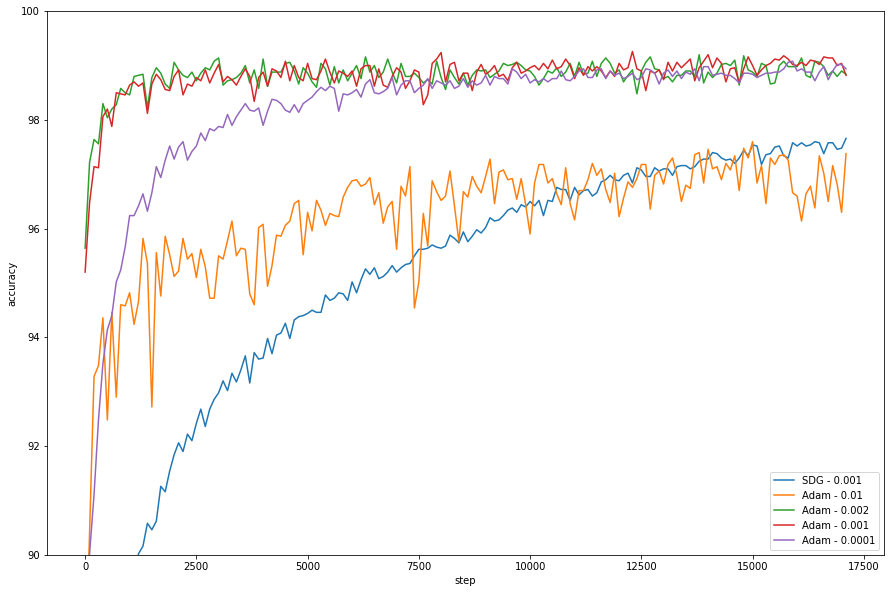

In [20]:
disc = np.arange(0, n_epochs * len(mnist_train) / batch_size, 100)

lbl = ["SDG - 0.001", "Adam - 0.01", "Adam - 0.002", "Adam - 0.001", "Adam - 0.0001"]
plt.figure(figsize=(15,10))

for i, acc in enumerate(va_list):
  plt.plot(disc, [100 * a for a in acc], label=lbl[i])

plt.xlabel('step')
plt.ylim(90, 100)
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [11]:
# best_cfg = optmin_tests[3]
best_cfg = optmin_tests[0]

### **Number of Layers**
Consider the following notation:
* **24C5** means a convolution layer with 24 feature maps using a 5x5 filter and stride 1
* **24C5S2** means a convolution layer with 24 feature maps using a 5x5 filter and stride 2
* **P2** means max pooling using 2x2 filter and stride 2
* **256** means fully connected dense layer with 256 units

Then our base model can be described as
* input - [24C5-P2] - [48C5-P2] - 10

3. The base model contains two convolutional blocks (convolutional layer + pooling). Compare the present model with the following two:
* input - [24C5-P2] - 256 - 10
* input - [24C5-P2] - [48C5-P2] - [64C5-P2] - 10

In [27]:
img_shape = [28, 28]

class ConvNN_2(nn.Module):
  def __init__(self, n_layers=2):
    super(ConvNN_2, self).__init__()
    kernel_sz = 5
    dim_fun = lambda x: x//2
    
    H_out = dim_fun(img_shape[0])
    W_out = dim_fun(img_shape[1])

    self.conv_layers = nn.ModuleList([ nn.Conv2d(1, 24, 5, padding=2) ])
    for i in range(1, n_layers):
      self.conv_layers.append(nn.Conv2d(24*i, 24*(i+1), 5, padding=2))
    
      H_out = dim_fun(H_out)
      W_out = dim_fun(W_out)

    self.fc = nn.Linear(24*n_layers * H_out * W_out, 10)
  
  def forward(self, x):
    for conv in self.conv_layers:
      x = F.relu(F.max_pool2d(conv(x), 2))
    
    x = x.view(x.size(0), -1)
    return self.fc(x)
  

In [31]:
va_list_layers = []
vl_list_layers = []

In [ ]:
for n in [1, 2, 3]:
  model = to_cuda(ConvNN_2(n_layers=n))
  vl, va = train(model, best_cfg)
  torch.save(model.state_dict(), "checkpoint/N_layers_{}.pt".format( str(n) ) )

  va_list_layers.append(va)
  vl_list_layers.append(vl)

  print('----------------------------')
  acc_test, error_test = test_step(model, test_loader)
  print("accuracy: {}".format(100 * acc_test))
  print('----------------------------')

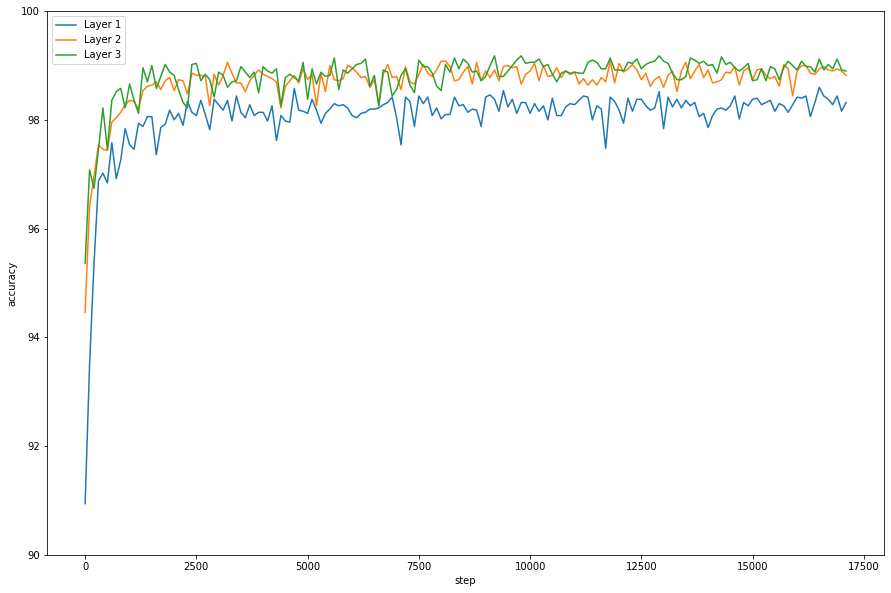

In [33]:
disc = np.arange(0, n_epochs * len(mnist_train) / batch_size, 100)

lbl = ["Layer 1", "Layer 2", "Layer 3"]
plt.figure(figsize=(15,10))

for i, acc in enumerate(va_list_layers):
  plt.plot(disc, [100 * a for a in acc], label=lbl[i])

plt.xlabel('step')
plt.ylim(90, 100)
plt.ylabel('accuracy')
plt.legend()
plt.show()

### **Feature maps**
Convolutional layers work by transforming feature representations in new ones using a collection of filters (convolutional kernels). There's no rigorous rule on how to choose how many filter should one use, as is the case for the number of fully connected layers. Therefore, one must in general test different architectures, while following known reccomendations.

4. Test your present model changing the number of feature maps in each convolutional layer. Here we present a recomendation of possible choices for the number of features, assuming the network has two convolutional layers
* input - [8C5-P2] - [16C5-P2] - 10
* input - [16C5-P2] - [32C5-P2] - 10
* input - [24C5-P2] - [48C5-P2] - 10
* input - [32C5-P2] - [64C5-P2] - 10
* input - [48C5-P2] - [96C5-P2] - 10
* input - [64C5-P2] - [128C5-P2] - 10

If the model has different one, three or more layers, than the above should be adjusted equivalently for the present case.

In [12]:
img_shape = [28, 28]

class ConvNN_3(nn.Module):
  def __init__(self, n_maps=24):
    super(ConvNN_3, self).__init__()
    self.cv1 = nn.Conv2d(1, n_maps, kernel_size=5, stride=1, padding=2)
    self.cv2 = nn.Conv2d(n_maps, n_maps * 2, kernel_size=5, stride=1, padding=2)
    self.fc = nn.Linear(7 * 7 * n_maps * 2, 10)

  def forward(self, x):
      out = F.relu(F.max_pool2d(self.cv1(x), 2))
      out = F.relu(F.max_pool2d(self.cv2(out), 2))
      out = out.view(out.size(0), -1)
      return self.fc(out)

In [13]:
va_list_maps = []
vl_list_maps = []

In [ ]:
for n in [8, 16, 24, 32, 48, 64]:
  model = to_cuda(ConvNN_3(n_maps=n))
  vl, va = train(model, best_cfg)
  torch.save(model.state_dict(), "checkpoint/N_features_maps_{}.pt".format( str(n) ) )

  va_list_maps.append(va)
  vl_list_maps.append(vl)

  print('----------------------------')
  acc_test, error_test = test_step(model, test_loader)
  print("accuracy: {}".format(100 * acc_test))
  print('----------------------------')

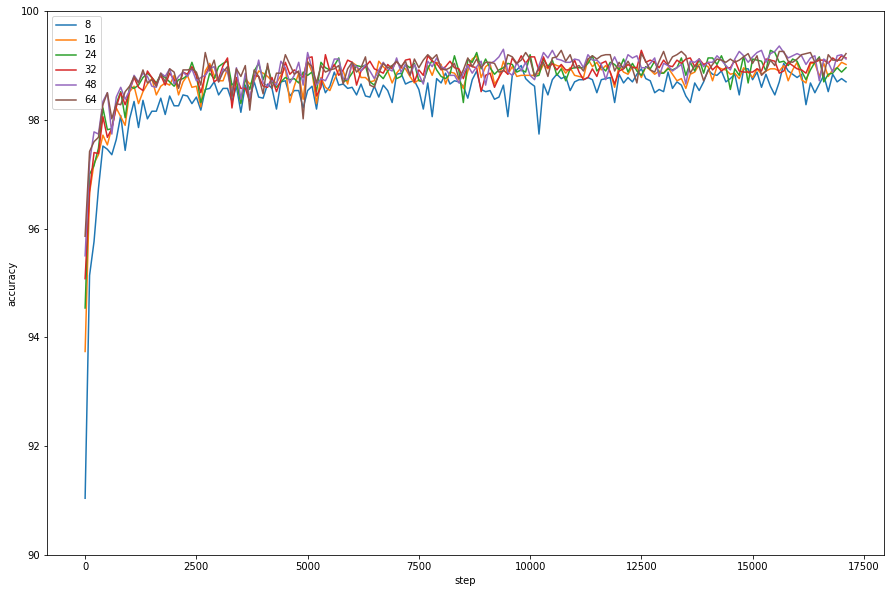

In [30]:
disc = np.arange(0, n_epochs * len(mnist_train) / batch_size, 100)

lbl = ["8", "16", "24", "32", "48", "64"]
plt.figure(figsize=(15,10))

for i, acc in enumerate(va_list_maps):
  plt.plot(disc, [100 * a for a in acc], label=lbl[i])

plt.xlabel('step')
plt.ylim(90, 100)
plt.ylabel('accuracy')
plt.legend()
plt.show()

### **Dense layer**
As of right now, we flatten and the output of our last convolutional layer and connect it into a dense layer, that provides the classification scores.

5. Add a hidden dense layer between the last convolutional layer and the last layer and compare the present model with the new one. Test hidden dense layers of sizes: 16, 64, 128, 256, 512, 1024.

In [ ]:
##############################################################################
# Code
##############################################################################

### **Dropout**
Dropout is a regularization technique that consists on temporarily droping out different sets of connections, chosen randomly, during training. Heuristically, dropout can be seen as simulating the training of simpler subnetworks simultaneously. Simpler networks are less prone to overfit, and thats the purpose of using it during training.

* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)

6. Add dropout layers in between each layer. These layers have a parameter `p` that tells the probability of a neuron to be dropped. Test the present model with the one using dropout for different values fo `p`. We recommend testing `p = 0.3, 0.4, 0.5, 0.6, 0.7`.



In [ ]:
##############################################################################
# Code
##############################################################################

### **Batch Normalization**

Batch normalization works by computing the mean and standard deviation of each minibatch, and renormalizing the batch accordingly. It also maintain two learnable parameters that compensate the randomness coming from the batch sampling.
* [functional.batch_norm](https://pytorch.org/docs/stable/nn.functional.html#batch-norm)
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

7. Add Batch Normalization layers to the model, and compare with your current state.

### **Extra**:
At this point, your network should have reached around more then 99% precision.
Nevertheless there are some archtecture changes that can sometimes improve even more the performance of your model.

8. Replace each conv. layer with 5x5 kernels in your network by two consecutive conv. layers with 3x3 kernels. For example, try replacing '32C5' with '32C3-32C3'. The two layers similarly mimic the 5x5 layer, but add more nonlinearities.

9. Instead of using a maxpooling layer you can replace it by another convolutional layer that has stride 2, and therefore perfomes a subsampling, but in a learnable way. That would mean, for example, to replace'P2' with a'32C5S2'.